In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


{"tags": ["hide_input"]}

{'tags': ['hide_input']}

### Descripción general de la data

In [2]:
df = pd.read_csv('../../data/machine_failure_data.csv')
df.describe()
{"tags": ["hide_input"]}

{'tags': ['hide_input']}

# Pregunta 1
Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.



Cambiamos los "Yes" y "No" de la columa "Failure_today" por unos y ceros. También simplificamos las direcciones en solo 4

In [3]:
for i in range(len(df)):
    if df.loc[i,"Failure_today"]=="Yes":
        df.loc[i,"Failure_today"]=1
    elif df.loc[i,"Failure_today"]=="No":
        df.loc[i,"Failure_today"]=0
    
    #Simplificación de direcciones
    if str(df.loc[i,"Parameter1_Dir"]).startswith("N"):
        df.loc[i,"Parameter1_Dir"]="N"
    elif str(df.loc[i,"Parameter1_Dir"]).startswith("S"):
        df.loc[i,"Parameter1_Dir"]="S"
    elif str(df.loc[i,"Parameter1_Dir"]).startswith("E"):
        df.loc[i,"Parameter1_Dir"]="E"
    elif str(df.loc[i,"Parameter1_Dir"]).startswith("W"):
        df.loc[i,"Parameter1_Dir"]="W"
        
    if str(df.loc[i,"Parameter2_9am"]).startswith("N"):
        df.loc[i,"Parameter2_9am"]="N"
    elif str(df.loc[i,"Parameter2_9am"]).startswith("S"):
        df.loc[i,"Parameter2_9am"]="S"
    elif str(df.loc[i,"Parameter2_9am"]).startswith("E"):
        df.loc[i,"Parameter2_9am"]="E"
    elif str(df.loc[i,"Parameter2_9am"]).startswith("W"):
        df.loc[i,"Parameter2_9am"]="W"
        
    if str(df.loc[i,"Parameter2_3pm"]).startswith("N"):
        df.loc[i,"Parameter2_3pm"]="N"
    elif str(df.loc[i,"Parameter2_3pm"]).startswith("S"):
        df.loc[i,"Parameter2_3pm"]="S"
    elif str(df.loc[i,"Parameter2_3pm"]).startswith("E"):
        df.loc[i,"Parameter2_3pm"]="E"
    elif str(df.loc[i,"Parameter2_3pm"]).startswith("W"):
        df.loc[i,"Parameter2_3pm"]="W"
    

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

Las filas que no tengan un valor en la variable Failure_today deben ser eliminadas. Hay muchas columnas con un gran porcentaje de valores nulos, eliminaremos las que tengan mas de un 30% de valores nulos. Luego de eliminar estas columnas, eliminaremos las filas que tengan valores nulos

In [4]:
eliminar=[]
nulos=df.isnull().sum()
for i in range(len(nulos)):
    if nulos[i]/len(df)>0.3:
        eliminar.append(df.columns[i])

for i in eliminar:
    print(f'Se ha eliminado {i}')
    df.drop(i,axis=1,inplace=True)
    
c=len(df)
df.dropna(inplace=True)
c=c-len(df)
print(f'Se han eliminado {c} filas por tener un valor nulo')

df['Failure_today'] = df['Failure_today'].astype(int)
df
{"tags": ["hide_input"]}

Se ha eliminado Evaporation
Se ha eliminado Electricity
Se ha eliminado Parameter6_9am
Se ha eliminado Parameter6_3pm
Se han eliminado 29268 filas por tener un valor nulo


{'tags': ['hide_input']}


Transformaremos la columna "Date" en varias columnas que nos permitan analizar el tiempo de mejor manera. También eliminaremos los datos del 2008 por su inconsistencia.

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df4=df["Date"]
df.drop("Date",axis=1, inplace=True)
df=df[df["Year"]>2008]
df

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

Haremos un analisis de correlación de las variables

{'tags': ['hide_input']}

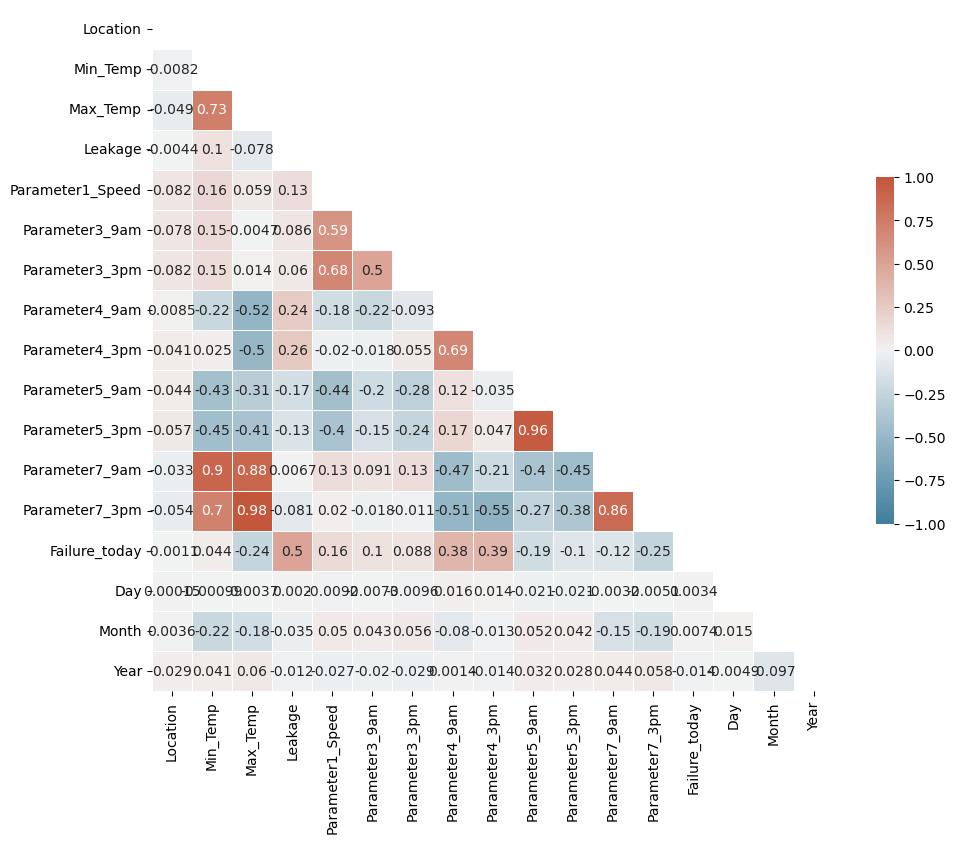

In [6]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

{"tags": ["hide_input"]}

Los paramétros 4, 5 y 7 tienen correlaciones por sobre 0.65 entre sus datos a las 9 am y las 3 pm. Así mismo, las temperaturas maximas y minimas tienen una correlación de 0.72. Reemplazaremos estas columnas por columnas que representen sus promedios. El parámetro 7 parece estar muy correlacionado con la temperatura, por lo que será eliminado

In [7]:
df["Parameter4"]=((df["Parameter4_9am"]+df["Parameter4_3pm"])/2)
df.drop("Parameter4_9am",axis=1, inplace=True)
df.drop("Parameter4_3pm",axis=1, inplace=True)

df["Parameter5"]=((df["Parameter5_9am"]+df["Parameter5_3pm"])/2)
df.drop("Parameter5_9am",axis=1, inplace=True)
df.drop("Parameter5_3pm",axis=1, inplace=True)

df["Parameter7"]=((df["Parameter7_9am"]+df["Parameter7_3pm"])/2)
df.drop("Parameter7_9am",axis=1, inplace=True)
df.drop("Parameter7_3pm",axis=1, inplace=True)

df["Temperature"]=((df["Min_Temp"]+df["Max_Temp"])/2)
df.drop("Min_Temp",axis=1, inplace=True)
df.drop("Max_Temp",axis=1, inplace=True)

df.drop("Parameter7", axis=1, inplace=True)
df

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

Ya que el parámetro 5 se mueve en una escala mucho más grande que nuestra variable dependiente, lo estandarizaremos.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Parameter5']] = scaler.fit_transform(df[['Parameter5']])

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

Creamos un gráfico con las fallas totales a nivel mensual para ver alguna posible estacionalidad en los datos. Podemos ver que en los meses iniciales y finales del año hay menos fallas en comparación con los meses centrales

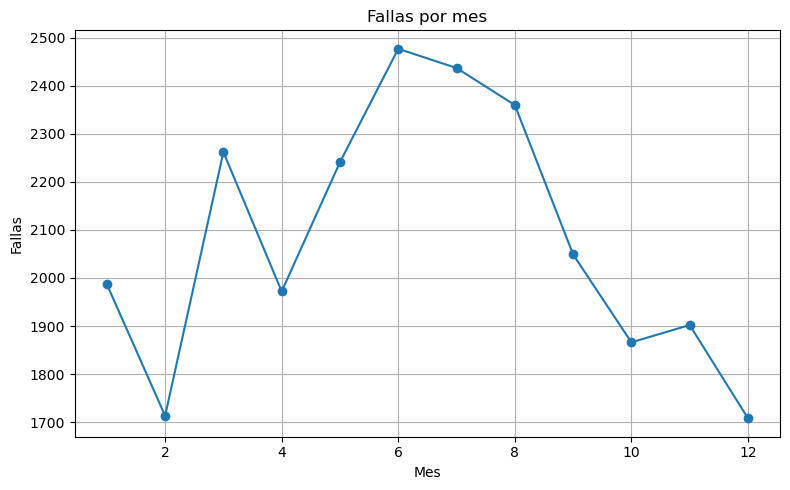

{'tags': ['hide_input']}

In [9]:
Mes=[i for i in range(1,13)]
Fallas=[0,0,0,0,0,0,0,0,0,0,0,0]
for k in range(2009,2018):
    df3=df[df["Year"]==k]
    
    D=df3["Failure_today"].sum()
    Cc=0
    for j in range(0,11):
        c=0
        for i in range(len(df3)):
            if df3.iloc[i,10]==j+2 and df3.iloc[i,8]==1:
                c=c+1
        Cc=Cc+c
        Fallas[j+1]+=c
    Fallas[0]+=D-Cc

dfm={"Mes":Mes,"Fallas":Fallas}
plt.figure(figsize=(8, 5))  # tamaño del gráfico
plt.plot(dfm['Mes'], dfm['Fallas'], marker='o', linestyle='-')
plt.title('Fallas por mes')
plt.xlabel('Mes')
plt.ylabel('Fallas')
plt.grid(True)
plt.tight_layout()
plt.show()

{"tags": ["hide_input"]}

Creamos un gráfico para ver la cantidad de fallas por año. No parece que las fallas aumenten o disminuyan con los años significativamente. Notar que el año 2017 solo esta registrado hasta la mitad, por lo que se entiende que tenga menos fallas.

[2827, 3266, 2998, 2702, 2860, 2784, 2820, 3323, 1394]


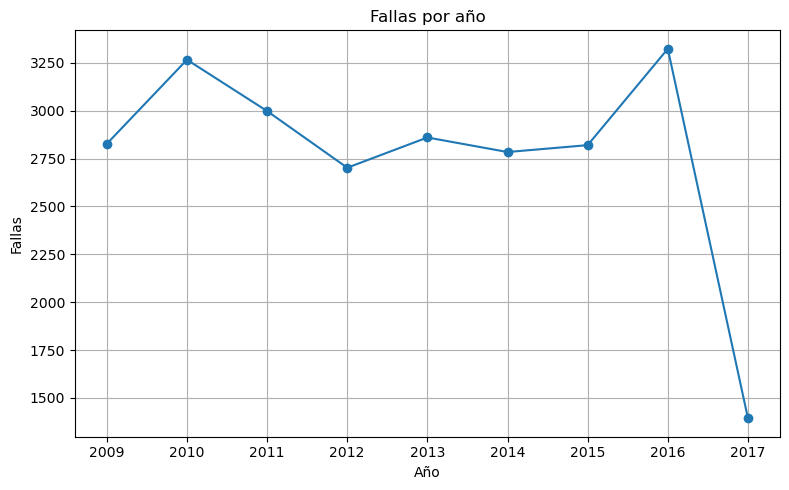

{'tags': ['hide_input']}

In [10]:
Año=[i for i in range(2009,2018)]
Fallas=[]
for k in range(2009,2018):
    dfm=df[df["Year"]==k]
    F=dfm["Failure_today"].sum()
    Fallas.append(F)
print(Fallas)
dfm={"Año":Año,"Fallas":Fallas}
plt.figure(figsize=(8, 5))  # tamaño del gráfico
plt.plot(dfm['Año'], dfm['Fallas'], marker='o', linestyle='-')
plt.title('Fallas por año')
plt.xlabel('Año')
plt.ylabel('Fallas')
plt.grid(True)
plt.tight_layout()
plt.show()    
   
{"tags": ["hide_input"]}

# Pregunta 2
Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

Creación de modelo MCO

In [11]:
model = smf.ols("Failure_today ~    Leakage+C(Parameter1_Dir)+ Parameter1_Speed+ C(Parameter1_Dir)*Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + Parameter3_3pm + C(Month)+ Day+ Year + Parameter4 + Parameter5+ C(Location)+ Temperature", data=df).fit()
print(model.summary())

{"tags": ["hide_input"]}

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     916.6
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:08:40   Log-Likelihood:                -33826.
No. Observations:              111179   AIC:                         6.780e+04
Df Residuals:                  111103   BIC:                         6.854e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

{'tags': ['hide_input']}

El día, el año, la temperatura y la interacción del parámetro 1 Dirección-Velocidad tienen valores p>0.05 y al eliminarlos del modelo el R cuadrado no disminuye, por lo que los eliminaremos. Finalmente nos quedaremos con los parámetros 1 (Dirección y velocidad), 2 (En sus 2 horarios), 3 (En sus 2 horarios), 4 y 5. También con las variables Location, Month y Leakage. La interpretación de los resultados es de la siguiente forma: Si la variable leakage aumenta en una unidad, la probabilidad de que ese día ocurra una falla aumentará en 0.01777, a excepción del parámetro 5 que está estandarizado, en ese caso un cambio de una desviación estándar del parámetro disminuye la probabilidad de falla en 0.04 . Factores como las fugas, la velocidad del viento y el parámetro 4 aumentan la probabilidad de fallas cuando aumentan. Las direcciones del viento S y W parecen aumentar la probabilidad de fallas con respecto a la dirección E, mientras que la dirección N parece disminuirla. El aumento del parámetro 3 a las 9am parece aumentar la probabilidad de falla, mientras que a las 3 pm parece disminuirla.

In [12]:
model = smf.ols("Failure_today ~   Leakage+ C(Parameter1_Dir)+ Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + Parameter3_3pm + C(Month) + Parameter4 + Parameter5 +C(Location)", data=df).fit()
print(model.summary())

{"tags": ["hide_input"]}

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     994.8
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:08:42   Log-Likelihood:                -33859.
No. Observations:              111179   AIC:                         6.786e+04
Df Residuals:                  111109   BIC:                         6.853e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

{'tags': ['hide_input']}

# Pregunta 3
Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

Podemos ver que ha habido un fallo al calcular los coeficientes de la regresión. Estos fallos pueden ocurrir por correlaciones entre las variables, por lo que revisaremos si hay alguna correlación muy alta

In [13]:
probit_model1 = smf.probit("Failure_today ~    Leakage+C(Parameter1_Dir)+ Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + Parameter3_3pm + C(Month) + Parameter4 + Parameter5 + C(Location)", data=df).fit()
print(probit_model1.summary())

mfx = probit_model1.get_margeff()
print(mfx.summary())

{"tags": ["hide_input"]}

Optimization terminated successfully.
         Current function value: nan
         Iterations 24
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               111179
Model:                         Probit   Df Residuals:                   111109
Method:                           MLE   Df Model:                           69
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                     nan
Time:                        22:08:46   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -59226.
Covariance Type:            nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                     nan        nan        nan        nan         nan         n

{'tags': ['hide_input']}

In [14]:
X=df.drop("Failure_today",axis=1)
X.corr()

,Location,Leakage,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Day,Month,Year,Parameter4,Parameter5,Temperature
Location,1.000000,-0.004391,0.082421,0.078436,0.081880,0.000145,0.003646,0.029313,0.027951,0.050594,-0.032194
Leakage,-0.004391,1.000000,0.130412,0.085633,0.060184,0.001954,-0.035109,-0.011593,0.271737,-0.148029,0.008449
Parameter1_Speed,0.082421,0.130412,1.000000,0.589986,0.679434,-0.009190,0.049568,-0.026627,-0.106684,-0.425855,0.115364
Parameter3_9am,0.078436,0.085633,0.589986,1.000000,0.499260,-0.007321,0.042794,-0.019739,-0.124955,-0.176197,0.074475
Parameter3_3pm,0.081880,0.060184,0.679434,0.499260,1.000000,-0.009575,0.056126,-0.029215,-0.017074,-0.265455,0.082626
Day,0.000145,0.001954,-0.009190,-0.007321,-0.009575,1.000000,0.014984,-0.004875,0.016577,-0.021383,-0.002593
Month,0.003646,-0.035109,0.049568,0.042794,0.056126,0.014984,1.000000,-0.097206,-0.048878,0.047244,-0.213105
Year,0.029313,-0.011593,-0.026627,-0.019739,-0.029215,-0.004875,-0.097206,1.000000,-0.007488,0.030608,0.054961
Parameter4,0.027951,0.271737,-0.106684,-0.124955,-0.017074,0.016577,-0.048878,-0.007488,1.000000,0.077695,-0.366543
Parameter5,0.050594,-0.148029,-0.425855,-0.176197,-0.265455,-0.021383,0.047244,0.030608,0.077695,1.000000,-0.434422


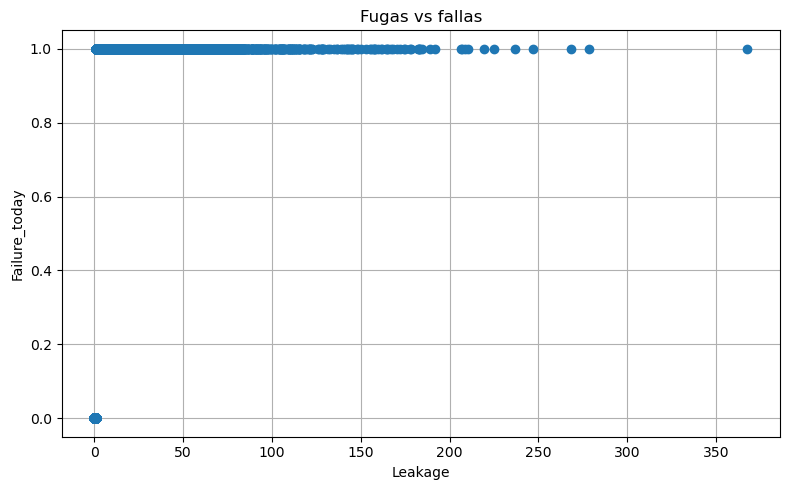

{'tags': ['hide_input']}

In [15]:
plt.figure(figsize=(8, 5))  # tamaño del gráfico
plt.plot(df['Leakage'], df['Failure_today'], marker='o', linestyle='')
plt.title('Fugas vs fallas')
plt.xlabel('Leakage')
plt.ylabel('Failure_today')
plt.grid(True)
plt.tight_layout()
plt.show() 

{"tags": ["hide_input"]}

Podemos ver que Parameter3_3pm tiene una correlación de mas de 0.65 con la variable Parameter1_Speed, por lo que la eliminamos. También la variable Leakage parece estar generando problemas en el modelo probablemente debido a que explica perfectamente a la variable dependiente, por lo que la eliminaremos. Además en este modelo, la variable Temperature sí es significativa, por lo que la añadiremos.

In [16]:
probit_model = smf.probit("Failure_today ~   Temperature+ C(Parameter1_Dir)+ Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + C(Month) + Parameter4 + Parameter5 + C(Location)", data=df).fit()
print(probit_model.summary())

mfx = probit_model.get_margeff()
print(mfx.summary())

{"tags": ["hide_input"]}

Optimization terminated successfully.
         Current function value: 0.380021
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               111179
Model:                         Probit   Df Residuals:                   111110
Method:                           MLE   Df Model:                           68
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2866
Time:                        22:09:12   Log-Likelihood:                -42250.
converged:                       True   LL-Null:                       -59226.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.1898      0.069    -60.303      0.000      -4.326      

{'tags': ['hide_input']}

Una vez obtenidos los resultados debemos fijarnos en los coeficientes dy/dx. En este caso una variación de una unidad de la variable Parameter4 aumentará la probabilidad de fallos en un 0.011 . Para el caso del parámetro 5, al estar estandarizado se interpreta como que al aumentar en una desviación estándar, la probabilidad de falla disminuye en 0.041 . Nuevamente la dirección norte en 2 de los 3 casos parece disminuir la probabilidad de falla (Con respecto a la dirección base), mientras que las otras direcciones parecen aumentarla. En general los parámetros no han cambiado mucho con respecto del modelo MCO a excepción del parámetro 4, que pasó de 0.0084 a 0.011

# Pregunta 4

Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [17]:
logit_model = smf.logit("Failure_today ~   Temperature+ Parameter5 +Parameter4 +C(Month)+ C(Location)+ Parameter3_9am + Parameter2_9am + Parameter2_3pm + Parameter1_Dir + Parameter1_Speed", data=df).fit(maxiter=100)
print(logit_model.summary())

mfx = logit_model.get_margeff()
print(mfx.summary())

{"tags": ["hide_input"]}

Optimization terminated successfully.
         Current function value: 0.380086
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               111179
Model:                          Logit   Df Residuals:                   111110
Method:                           MLE   Df Model:                           68
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2865
Time:                        22:09:40   Log-Likelihood:                -42258.
converged:                       True   LL-Null:                       -59226.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.2262      0.125    -57.918      0.000      -7.471      -6.982
C(

{'tags': ['hide_input']}

In [18]:
params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[57:68 , ])

{"tags": ["hide_input"]}

Odds Ratios
                     Odds Ratio        5%       95%
Parameter2_9am[T.W]    1.695810  1.950345  1.818630
Parameter2_3pm[T.N]    0.794104  0.911787  0.850913
Parameter2_3pm[T.S]    1.094233  1.239606  1.164654
Parameter2_3pm[T.W]    1.209857  1.400624  1.301751
Parameter1_Dir[T.N]    0.748795  0.863886  0.804284
Parameter1_Dir[T.S]    0.971744  1.106229  1.036809
Parameter1_Dir[T.W]    1.024261  1.187095  1.102676
Temperature            0.944845  0.958425  0.951610
Parameter5             0.681624  0.712869  0.697071
Parameter4             1.092747  1.095988  1.094366
Parameter3_9am         1.022256  1.027853  1.025051


{'tags': ['hide_input']}

No se observan grandes variaciones con respecto al modelo probit y la forma en la que se interpretan los resultados es la misma. Los parámetros 4, 3 y 1 parecen aumentar la probabilidad de fallos, mientras que el parámetro 5 la disminuye. Con respecto a los Odds ratios la interpretación es como sigue: Si el parámetro 4 aumenta en una unidad, las probabilidades de que se produzca un fallo se multiplican por 1.09 . Por otro lado, si el parámetro 5 aumenta una desviación estándar, las probabilidades de que ocurra una falla se multiplican por 0.7 .

# PREGUNTA 5
Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?                            
Como se puede apreciar en la tabla siguiente, los 3 modelos ofrecen resuestas muy similares, aunque podemos descartar el método MCO como el más adecuado porque está hecho para predecir variables continuas, mientras que logit y probit se especializan en variables binarias. Entre logit y probit no hay mucha diferencia en los resultados, pero elegiría el modelo logit por la posibilidad de analizar los odds ratios.                         
El parámetro 1 de velocidad, el parámetro 3 a las 9am, el parámetro 4 y el parámetro 5, resultaron ser robustos a la especificación, pues sus magnitudes y signos se mantuvieron similares a traves de los 3 modelos. Pasando a las variables categóricas, los meses y las locaciones también mantuvieron valores similares.

In [19]:
results_df = pd.DataFrame({
    'Modelo MCO': model.params,
    'Modelo Probit': probit_model.get_margeff().summary_frame()["dy/dx"],
    'Modelo Logit': logit_model.get_margeff().summary_frame()["dy/dx"]
})

results_df = results_df.round(3)

results_df.tail(12)

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

# PREGUNTA 6 
Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

In [20]:
df5=df.drop(["Parameter1_Dir","Parameter2_9am","Parameter2_3pm","Day","Month","Year"],axis=1)
df5["Date"]=df4
df5['Date'] = pd.to_datetime(df5['Date'])
df5['mes'] = df5['Date'].dt.to_period('M')


df_m = df5.groupby(["mes","Location"]).agg({
    'Leakage': 'mean',
    'Parameter1_Speed': 'mean',
    'Parameter3_9am': 'mean',
    'Parameter3_3pm': 'mean',
    'Parameter4': 'mean',
    'Parameter5': 'mean',
    'Temperature': 'mean',
    'Failure_today': 'sum'
}).reset_index()

df_m['Month'] = df_m['mes'].dt.month
df_m

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

In [21]:
poisson = smf.glm(formula='Failure_today ~ C(Location) + Parameter3_9am+ Parameter3_3pm + Parameter4 + Parameter5 + C(Month)', data=df_m, family=sm.families.Poisson()).fit()

print(poisson.summary())
print("Resultados exponenciales")
print(np.exp(poisson.params))

{"tags": ["hide_input"]}

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4017
Model Family:                 Poisson   Df Model:                           58
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9191.2
Date:                Thu, 24 Apr 2025   Deviance:                       4857.4
Time:                        22:11:02   Pearson chi2:                 4.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8501
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.1452      0.08

{'tags': ['hide_input']}

{'tags': ['hide_input']}

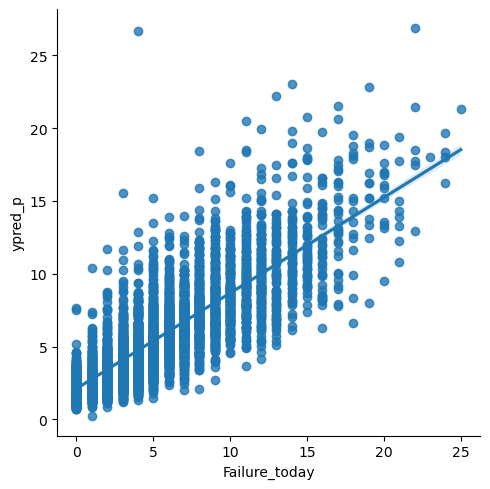

In [22]:
predictions = poisson.predict(df_m)
df_m['ypred_p'] = predictions
sns.lmplot(data=df_m, x='Failure_today', y='ypred_p')

{"tags": ["hide_input"]}

Eliminamos el parámetro 1 de velocidad porque su valor p era demasiado alto. Los coeficientes e^B representan el multiplicador que se debe aplicar a la media esperada cuando la variable aumenta en una unidad (O una desviación estándar en el caso del Parámetro 5). Por ejemplo, si el parámetro 4 aumenta en una unidad, la media esperada de los fallos se multiplicará por 1.055 . Estos resultados se condicen con los anteriores en el sentido de si aumentan o disminuyen la probabilidad de fallas.

# PREGUNTA 7 
Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

Podemos ver que el estadístico de sobredispersión es cercano a 1, por lo que el modelo Poisson puede ser adecuado. Aunque es mayor que uno, por lo que tal vez se podría considerar un poco de sobredispersión.

In [23]:
residuos_pearson = poisson.resid_pearson

pearson_chi2 = np.sum(residuos_pearson**2)
grados_libertad = poisson.df_resid

dispersion = pearson_chi2 / grados_libertad
print("Estadístico de dispersión:", dispersion)

{"tags": ["hide_input"]}

Estadístico de dispersión: 1.0855149563214965


{'tags': ['hide_input']}

Podemos ver que el estimador para ln(Alfa) es 0.0094, por lo que usaremos Alfa=1.0094

In [24]:
aux=((df_m['Failure_today']-predictions)**2-predictions)/predictions
auxr=sm.OLS(aux,predictions).fit()
print(auxr.summary())
Alfa=np.exp(auxr.params[0])
print("")
print("Alfa es ",Alfa)

{"tags": ["hide_input"]}

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              9.670
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                     0.00189
Time:                        22:11:03   Log-Likelihood:                         -7638.9
No. Observations:                4076   AIC:                                  1.528e+04
Df Residuals:                    4075   BIC:                                  1.529e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

{'tags': ['hide_input']}

# PREGUNTA 8 
Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.


Los resultados se interpretan de la misma forma que los del modelo poisson: Con los coeficientes exponenciales. En este caso, si el parámetro 4 aumenta una unidad, la media esperada se multiplicará por 1.063

In [25]:
negbin= smf.glm(formula='Failure_today ~ C(Location) + Parameter3_9am+ Parameter3_3pm + Parameter4 + Parameter5 + C(Month)',
    data=df_m,
    family=sm.families.NegativeBinomial(alpha=Alfa)
).fit()
print(negbin.summary())
print("Resultados exponenciales")
print(np.exp(negbin.params))

{"tags": ["hide_input"]}

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4017
Model Family:        NegativeBinomial   Df Model:                           58
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11168.
Date:                Thu, 24 Apr 2025   Deviance:                       1116.7
Time:                        22:11:03   Pearson chi2:                     802.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2637
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.4438      0.21

{'tags': ['hide_input']}

{'tags': ['hide_input']}

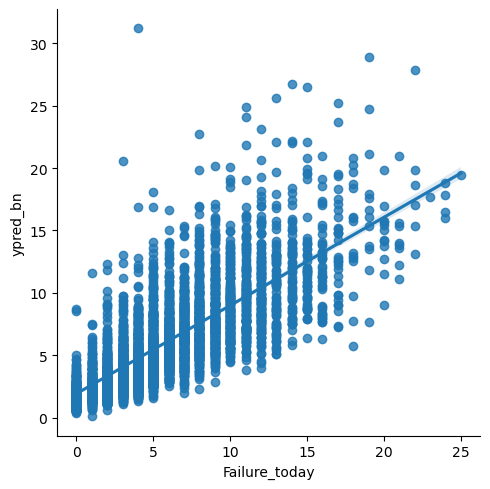

In [26]:
df_m['ypred_bn'] = negbin.predict(df_m)
sns.lmplot(data=df_m, x='Failure_today', y='ypred_bn')

{"tags": ["hide_input"]}

# PREGUNTA 9 
Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

Como se puede apreciar en la tablas siguientes, los valores predichos son similares aunque el modelo poisson resultó ser más preciso al predecir los resultados de nuestro data set y, dado que nuestro modelo no presenta sobredispersión, nos quedaremos con el modelo poisson. 

In [27]:
df_m.loc[:,"ypred_p":"ypred_bn"]

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

In [28]:
df_m["y-ypred_p"]=(df_m["Failure_today"]-df_m["ypred_p"]).abs()
df_m["y-ypred_bn"]=(df_m["Failure_today"]-df_m["ypred_bn"]).abs()
df_m.loc[:,"y-ypred_p":"y-ypred_bn"]

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

In [29]:
print("Distancia total al valor real del modelo Poisson: ",df_m["y-ypred_p"].sum())
print("Distancia total al valor real del modelo Binomial Negativa: ",df_m["y-ypred_bn"].sum())

{"tags": ["hide_input"]}

Distancia total al valor real del modelo Poisson:  7982.864960537252
Distancia total al valor real del modelo Binomial Negativa:  8521.693187651039


{'tags': ['hide_input']}

En la tabla siguiente podemos ver los coeficientes asignados a cada variable por modelo. En ella podemos apreciar que las diferencias en las variables continuas es muy pequeña (La mayor diferencia es de 0.01), por lo que podríamos decir que son robustas a la especificación. Por otro lado las diferencias entre coeficientes de las ubicaciones y meses son mas grandes en general (Llegando hasta diferencias de 0.11). Diremos que estas no son robustas a la especificación.

In [30]:
comparacion = pd.DataFrame({
    'Poisson': np.exp(poisson.params),
    'Binomial_Neg': np.exp(negbin.params)
    
})
comparacion["Poisson-Binomial"]=(comparacion["Poisson"]-comparacion["Binomial_Neg"]).abs()
comparacion

{"tags": ["hide_input"]}

{'tags': ['hide_input']}

# Transformación a PDF

In [31]:
!jupyter nbconvert --to pdf --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags="['hide_input']" Tarea1_Meza_Núñez.ipynb

C:\Users\franm\anaconda3\lib\site-packages\traitlets\traitlets.py:2915: FutureWarning: --TagRemovePreprocessor.remove_input_tags=['hide_input'] for containers is deprecated in traitlets 5.0. You can pass `--TagRemovePreprocessor.remove_input_tags item` ... multiple times to add items to a list.
  warn(
[NbConvertApp] Converting notebook Tarea1_Meza_Núñez.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'Tarea1_Meza_Núñez.ipynb'
Traceback (most recent call last):
  File "C:\Users\franm\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 488, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "C:\Users\franm\anaconda3\lib\site-packages\nbconvert\exporters\exporter.py", line 189, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "C:\Users\franm\anaconda3\lib\site-packages\nbconvert\exporters\exporter.py", line 206, in from_file
    return self.from_notebook_node(
  File "C:\Users\franm\anaconda3\lib\site-p